In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from pathlib import Path
import numpy as np
import PIL
import PIL.Image
import json
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

#change working directory to root
ROOT_DIR = os.getcwd()
while os.path.basename(ROOT_DIR) != 'VisIrNet':
    ROOT_DIR = os.path.abspath(os.path.join(ROOT_DIR,'..'))
sys.path.insert(0,ROOT_DIR)
os.chdir(ROOT_DIR)

ROOT_DIR = Path(ROOT_DIR)

print(tf.__version__)
devices = tf.config.list_physical_devices('GPU')
print("len(devices): ", len(devices))
print(f"available GPUs: {devices}");

from collections import defaultdict



2.14.0
len(devices):  1
available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# extract important metrics from logs

logs_path = ROOT_DIR / 'logs'



## backbone 

```python

## helper functions

```

In [3]:
## helper functions

def parse_backbone_log(logs):
    """
        'model-name',
        'epochs',
        'loss_function',
        'resumed_from',
        'train_size',
        'test_size',
        'tag_name',
        'per_epoch_metrics',
        'training_time'
    """
    #
    # interested_in = ['fir_frgb', 'frgb_Irgb', 'fir_Irgb']
    interested_in = ['total_loss']


    # exatract the initial and final values
    training_logs = logs["per_epoch_metrics"]["train_loss"]
    test_logs = logs["per_epoch_metrics"]["test_results"]
    
    _filtered_logs={}

    _filtered_logs.update({f"Train": v for k,v in training_logs.items() if k in interested_in})
    _filtered_logs.update({f"Test": v for k,v in test_logs.items() if k in interested_in})
    
    values_dict = {logs["loss_function"]: _filtered_logs}
    return dict(values_dict)


def handle_backbone(log_dir, backbone_logs):
    
    backbone_parsed_dict = defaultdict(list)
    
    for b_logs in backbone_logs:        
        # read the json 
        with open(log_dir / b_logs) as f:
            example_logs = json.load(f)
            parsed_dict = parse_backbone_log(example_logs)
        
        # add the parsed dict to the backbone_parsed_dict
        backbone_parsed_dict.update(parsed_dict)
            
    return dict(backbone_parsed_dict)
    
    

In [4]:
# plts

def handle_learning_curve_plots(history_dict,d_name):
    """
    
        Given training history dict for different loss functions,
        plot the training and validation loss and accuracy curves
    """
    print("dataset_name: ", d_name)
    print("*"*50)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'{d_name} Learning Curves')
    
    titles_dict = {
        "sse_pixel": "Pixel Sum Squared Error",
        "mae_pixel": "Pixel Mean Absolute Error",
        "mse_pixel": "Pixel Mean Squared Error",
        "ssim_pixel": "Pixel Structural Similarity Index"
    }
    
    raveled_axes = axes.ravel() 
            
    for idx, (k , v) in enumerate(history_dict.items()):
        print(f"loss: {k}")
        _logs_df = pd.DataFrame(v)
        with sns.axes_style("whitegrid"):
            sns.lineplot(data= _logs_df, ax=raveled_axes[idx],linewidth=2.5)
            raveled_axes[idx].set_title(f'{titles_dict[k]}')
            raveled_axes[idx].set_xlabel('' if idx <2  else "Epochs")
            raveled_axes[idx].set_ylabel('')
            raveled_axes[idx].tick_params(axis='x', labelbottom=(True if idx > 1 else False))
            raveled_axes[idx].tick_params(axis='y', labelleft=True)
            # axes[i, j].legend(ncol=1, fontsize=5, loc="upper center", frameon=False).remove()      
        # # show ticks for the last row
    # Adjust spacing
    plt.tight_layout()
    plt.fontsize = 20
    # Show the plots
    # plt.show()    
    file_name = f'{d_name}_learning_curve'
    save_path = Path("resources/learning_curve_s/")
    save_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(str(save_path/f'{file_name}.png'), dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()
    print("*"*50)


dataset_name:  VEDAI
**************************************************
loss: mae_pixel


AttributeError: Line2D.set() got an unexpected keyword argument 'fontsize'

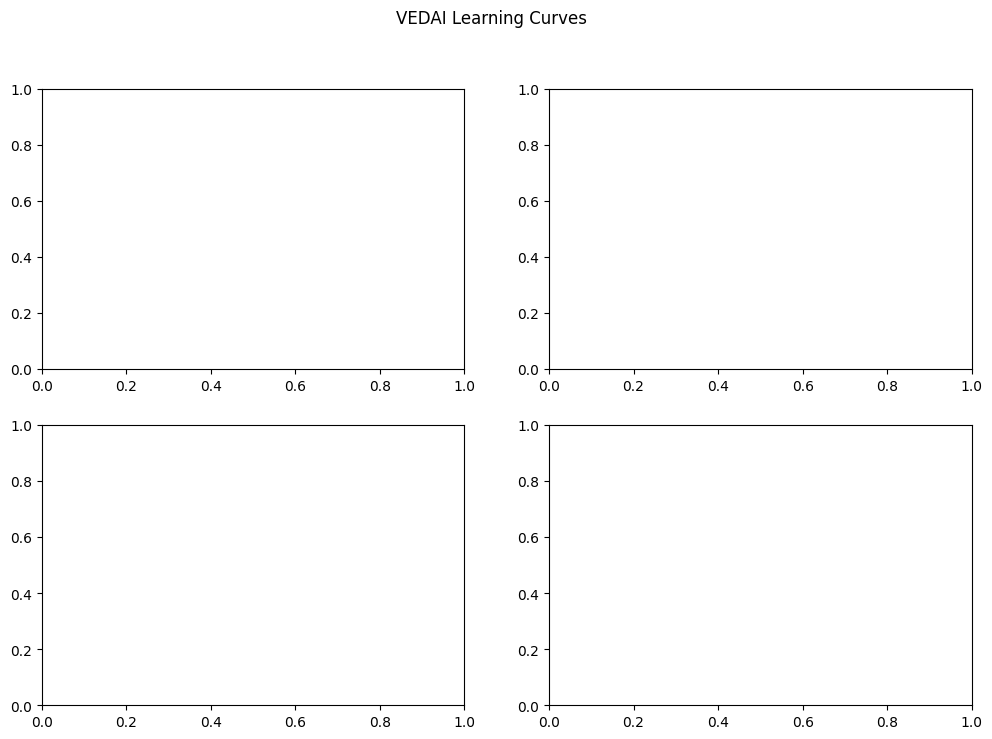

In [5]:

# get all directories in logs_path
log_dirs = [x for x in logs_path.iterdir() if x.is_dir() and x.name != 'tensorboard']
dataset_with_logs = [d.name for d in log_dirs]



for log_dir, d_name in zip(log_dirs,dataset_with_logs):
    # per dataset logs
    per_dataset_logs = [x.name for x in log_dir.glob('*.json')]

    backbone_logs = list(filter(lambda x: 'regressionBlock' not in x,per_dataset_logs))
    backbone_parsed = handle_backbone(log_dir, backbone_logs)
    # regression_parsed = handle_regression(log_dir, regressionBlock_logs)
    
    handle_learning_curve_plots(backbone_parsed,d_name)


